Cell 1: Environment Setup,Logging & Data Loading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from scipy.stats import poisson

# --- LOGGING SETUP ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def load_dataset(path):
    """Loads the cleaned dataset and sets PatientID as index."""
    try:
        data = pd.read_csv(path, index_col='PatientID')
        logger.info(f"Successfully loaded data. Shape: {data.shape}")
        return data
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        return None

# Execution
path = '../data/parkinsons_cleaned.csv'
df = load_dataset(path)

2026-01-14 20:59:05,224 - INFO - Successfully loaded data. Shape: (2105, 33)


Cell 2: Global Correlation Heatmap

2026-01-14 20:59:05,237 - INFO - Generating global correlation heatmap.


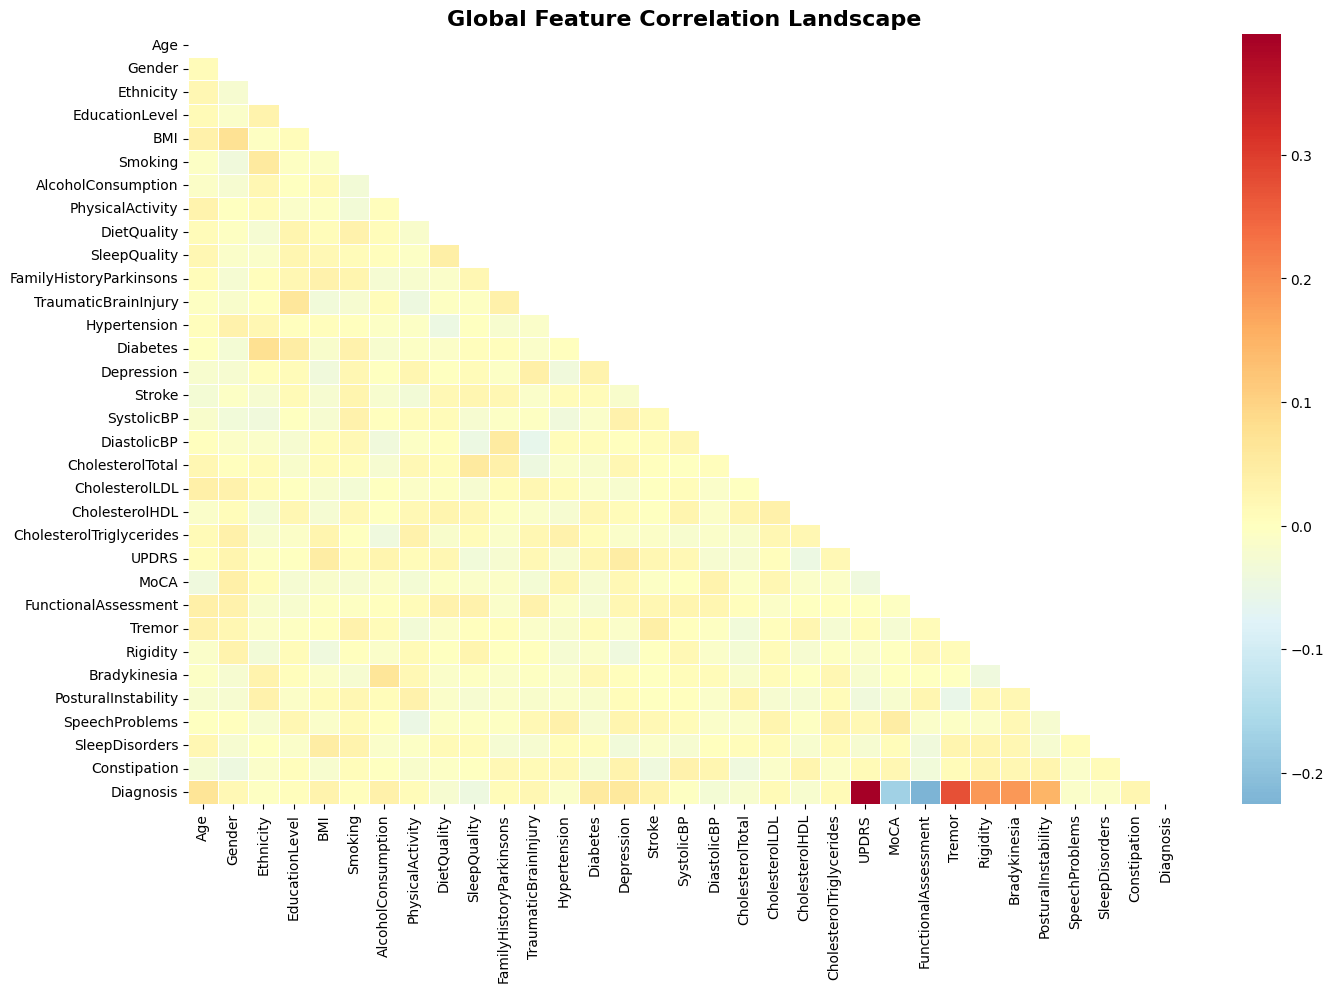

In [2]:
def plot_global_heatmap(data):
    """Generates a professional heatmap for the entire feature set."""
    logger.info("Generating global correlation heatmap.")
    corr_matrix = data.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    plt.figure(figsize=(16, 10))
    sns.heatmap(corr_matrix, mask=mask, cmap='RdYlBu_r', center=0, linewidths=0.5)
    plt.title('Global Feature Correlation Landscape', fontsize=16, fontweight='bold')
    plt.show()

# Execution
if df is not None:
    plot_global_heatmap(df)

Cell 3: Risk/Protective Factors vs. Clinical Symptoms

2026-01-14 20:59:05,862 - INFO - Generating correlation profile for target: Diagnosis


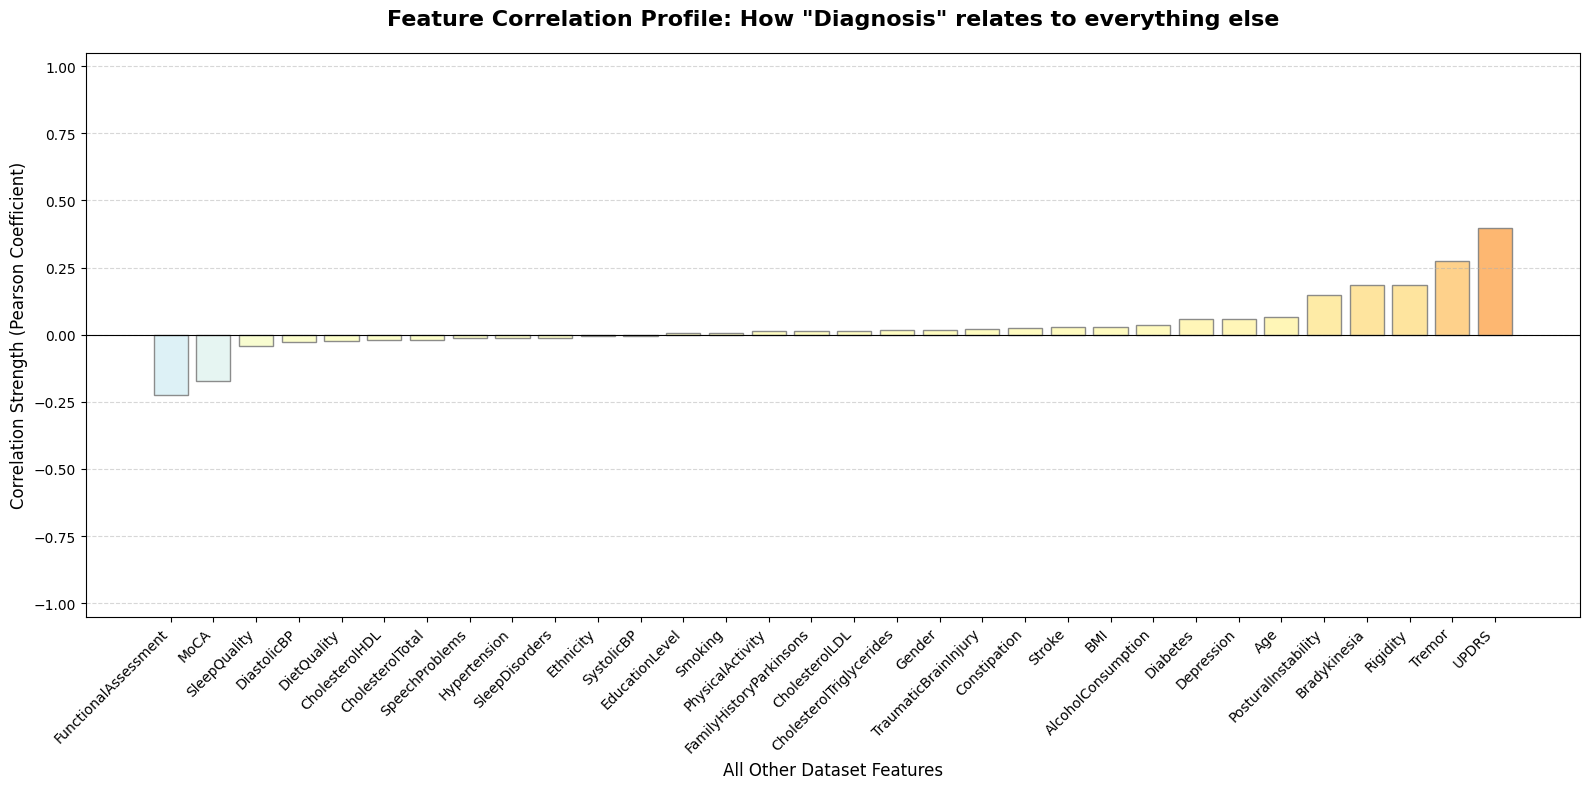

In [3]:
def plot_feature_correlation_profile(data, target_feature):
    """
    Generates a bar chart showing how a specific 'target_feature' correlates 
    with EVERY other feature in the dataset.
    This is equivalent to viewing a single row/column of a heatmap as bars.
    """
    if data.empty or target_feature not in data.columns:
        logger.warning(f"Cannot plot profile for missing feature: {target_feature}")
        return

    logger.info(f"Generating correlation profile for target: {target_feature}")
    
    # 1. Calculate the full correlation matrix
    corr_matrix = data.corr()
    
    # 2. Extract only the correlations for our target feature
    # We drop the target feature itself because correlation with self is always 1.0
    target_corrs = corr_matrix[target_feature].drop(target_feature).sort_values()
    
    # 3. Define "Heatmap-style" colors
    # Red for strong positive correlations, Blue for strong negative
    colors = plt.cm.RdYlBu_r((target_corrs + 1) / 2) # Normalize values to 0-1 for colormap

    plt.figure(figsize=(16, 8))
    
    # Create the bar plot
    bars = plt.bar(target_corrs.index, target_corrs.values, color=colors, edgecolor='grey', alpha=0.9)
    
    # 4. Styling for a professional look
    plt.title(f'Feature Correlation Profile: How "{target_feature}" relates to everything else', 
              fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Correlation Strength (Pearson Coefficient)', fontsize=12)
    plt.xlabel('All Other Dataset Features', fontsize=12)
    
    # IMPORTANT: Set consistent Y-axis limits (-1 to 1) 
    # This ensures graphs for different features are directly comparable.
    plt.ylim(-1.05, 1.05) 
    
    # Add a zero line for clarity
    plt.axhline(0, color='black', linewidth=0.8, linestyle='-')
    
    # Rotate labels so they don't overlap
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

#  Execution 
if 'df' in locals() and df is not None and not df.empty:
    plot_feature_correlation_profile(df, 'Diagnosis')
    
  

Cell 4: Defining the Sick Population for Progression Analysis

In [4]:
def extract_sick_population(data):
    """
    Filters the dataset to include only patients diagnosed with Parkinson's.
    """
    sick_subset = data[data['Diagnosis'] == 1].copy()
    logger.info(f"Population filtered. Analyzing {len(sick_subset)} diagnosed patients.")
    return sick_subset

# --- EXECUTION ---
if df is not None:
    sick_df = extract_sick_population(df)

2026-01-14 20:59:06,301 - INFO - Population filtered. Analyzing 1304 diagnosed patients.


cell 5:sick population Correlation Heatmap

2026-01-14 20:59:06,317 - INFO - Generating internal correlation heatmap for sick population.


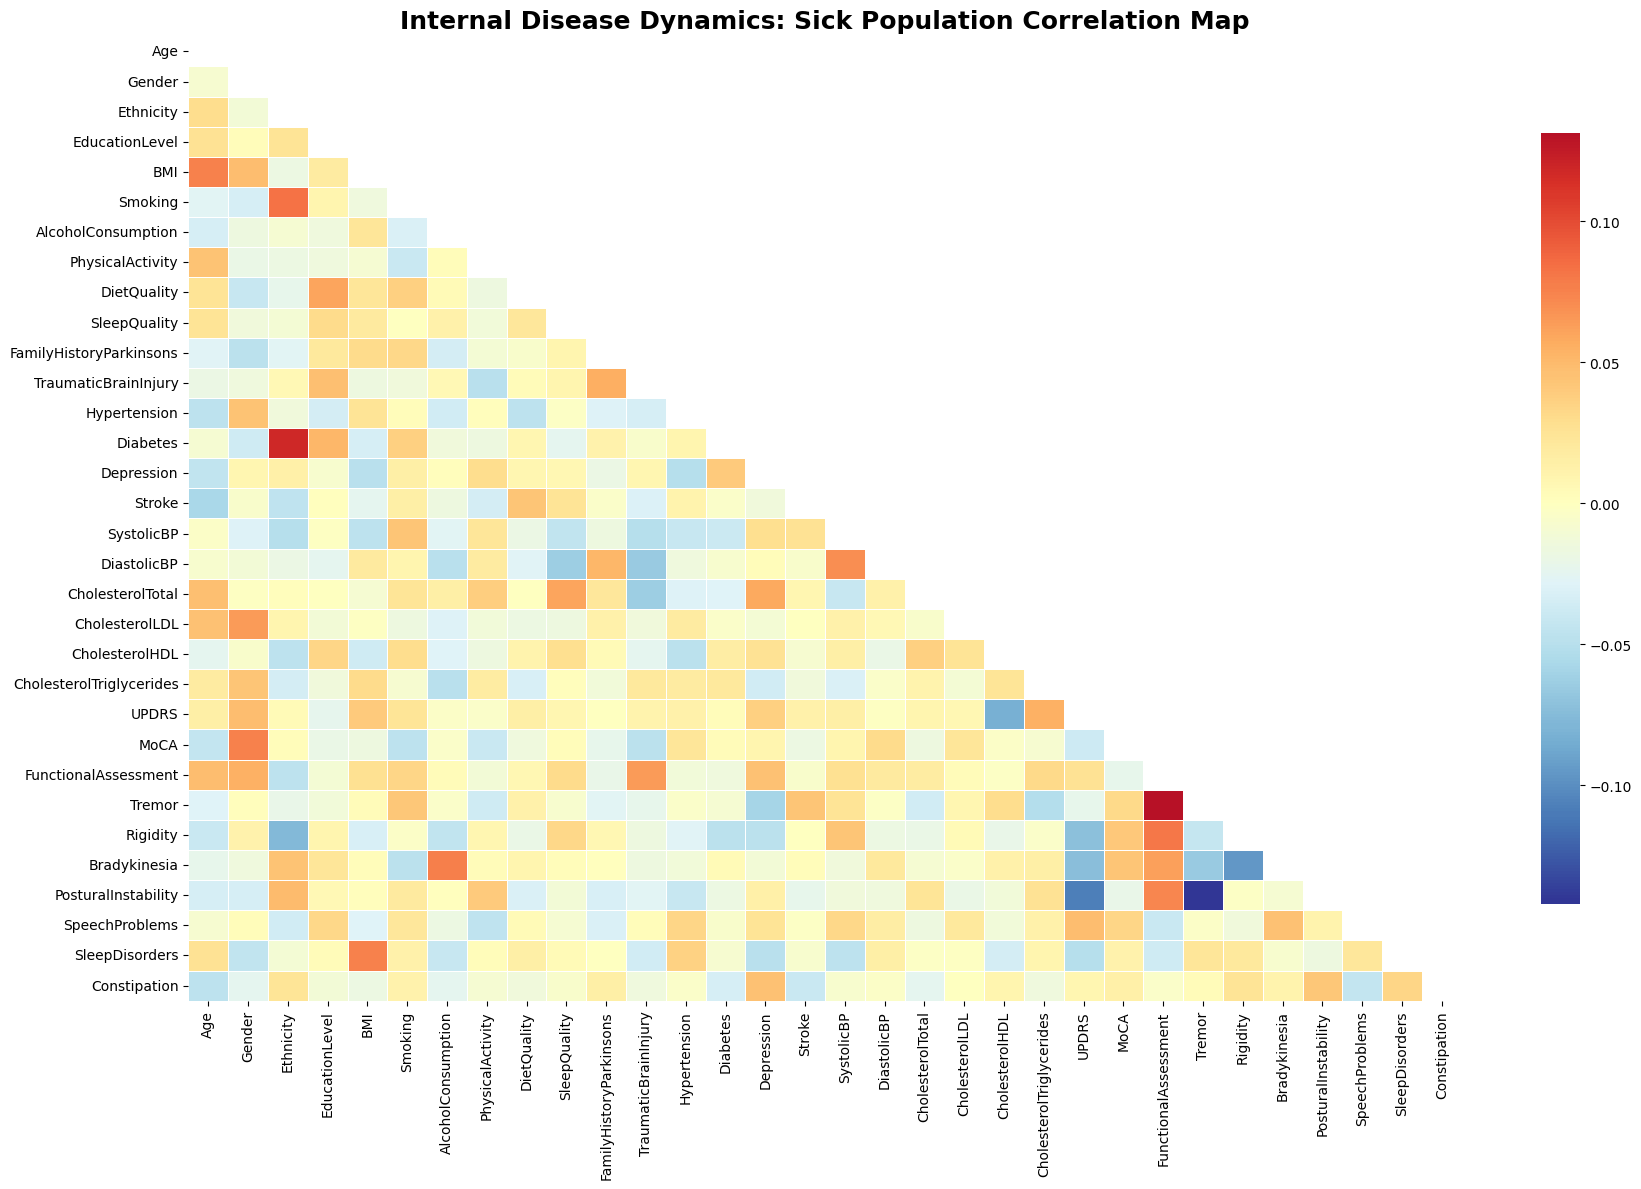

In [5]:
def plot_sick_population_heatmap(sick_data):
    """
    Generates a heatmap specifically for the diagnosed population.
    Removes constant features and visualizes internal disease dynamics.
    """
    if sick_data.empty:
        logger.warning("Sick dataset is empty. Cannot generate heatmap.")
        return

    logger.info("Generating internal correlation heatmap for sick population.")
    
    # 1. Clean data for the heatmap
    # We drop 'Diagnosis' because it's always 1 (constant) for this group
    # and would cause empty rows/columns in the correlation matrix.
    plot_df = sick_data.drop(columns=['Diagnosis'], errors='ignore')
    
    # 2. Calculate correlation
    corr_matrix = plot_df.corr()
    
    # 3. Create a mask to hide the upper triangle (it's a mirror image)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    plt.figure(figsize=(18, 12))
    
    # 4. Draw the heatmap
    sns.heatmap(
        corr_matrix, 
        mask=mask, 
        cmap='RdYlBu_r', 
        center=0, 
        annot=False, # Set to True if you want to see the numbers
        linewidths=0.5,
        cbar_kws={"shrink": .8}
    )
    
    plt.title('Internal Disease Dynamics: Sick Population Correlation Map', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

# EXECUTION
if 'sick_df' in locals() and not sick_df.empty:
    plot_sick_population_heatmap(sick_df)

Cell 6: Comparing the Three Severity Metrics

2026-01-14 20:59:07,074 - INFO - Comparing distributions of UPDRS, MoCA, and Functional Assessment.


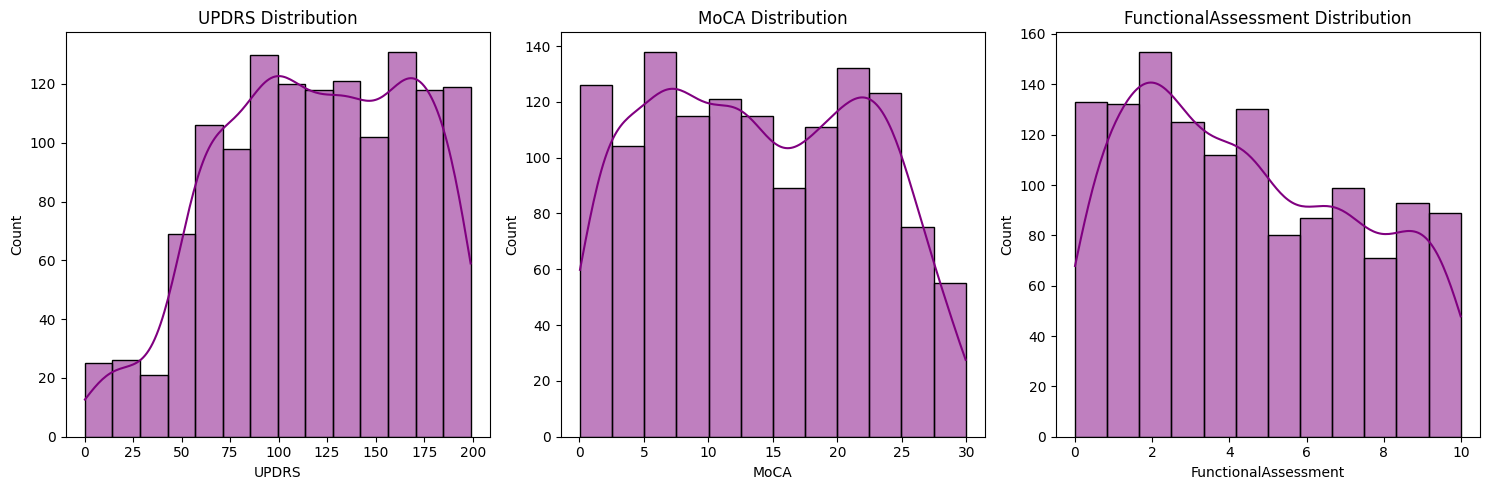

In [6]:
def plot_severity_distributions(data):
    """Visualizes the distribution and scale of the three primary severity metrics."""
    logger.info("Comparing distributions of UPDRS, MoCA, and Functional Assessment.")
    metrics = ['UPDRS', 'MoCA', 'FunctionalAssessment']
    
    plt.figure(figsize=(15, 5))
    for i, m in enumerate(metrics, 1):
        plt.subplot(1, 3, i)
        sns.histplot(data[m], kde=True, color='purple')
        plt.title(f'{m} Distribution')
    plt.tight_layout()
    plt.show()

# Execution
plot_severity_distributions(sick_df)

Cell 7: Metric Dissociation & Absolute Correlation Strength

2026-01-14 20:59:07,807 - INFO - Executing dissociation analysis.


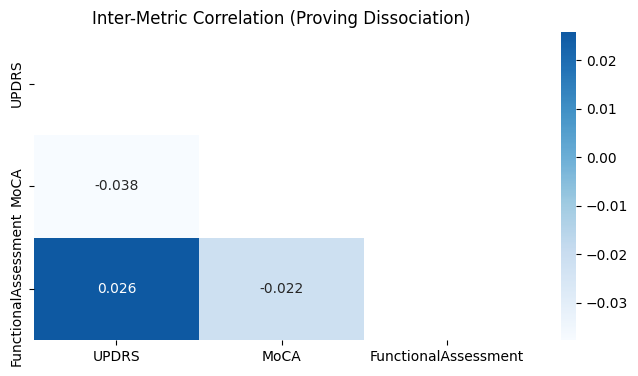

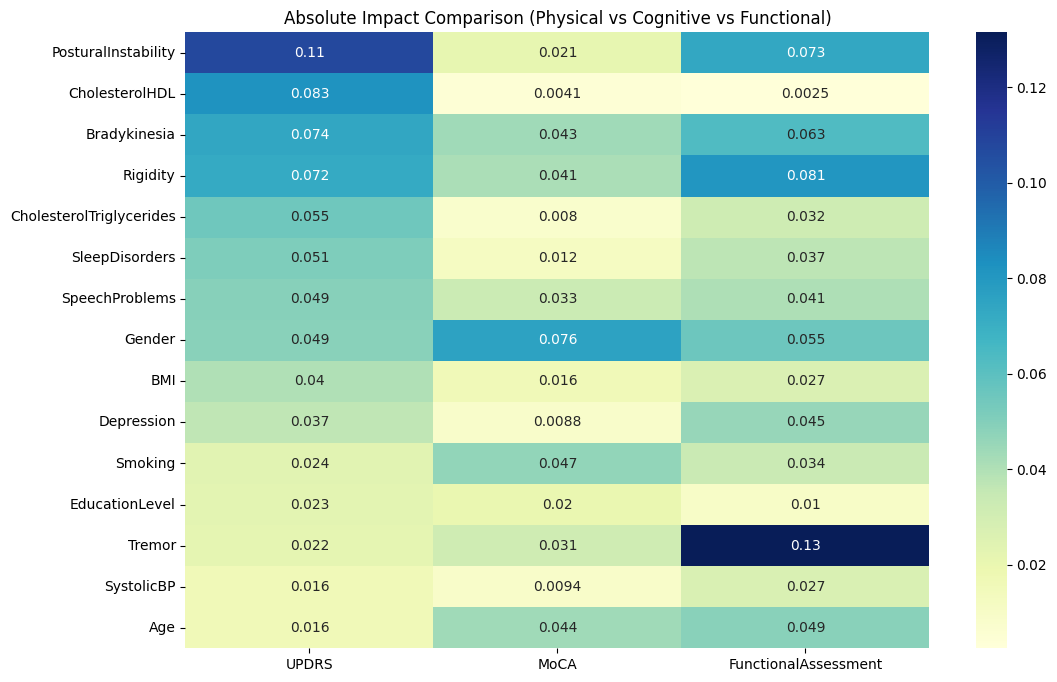

In [7]:
def analyze_metric_dissociation(data):
    """
    Investigates the independence of clinical metrics and their specific drivers.
    Uses absolute correlation values to compare the magnitude of impact across domains.
    """
    logger.info("Executing dissociation analysis.")
    metrics = ['UPDRS', 'MoCA', 'FunctionalAssessment']
    
    # 1. Inter-Metric Correlation with upper triangle mask
    # Proves if clinical scores move together or represent independent symptoms
    inter_corr = data[metrics].corr()
    mask_inter = np.triu(np.ones_like(inter_corr, dtype=bool))
    
    plt.figure(figsize=(8, 4))
    sns.heatmap(inter_corr, annot=True, mask=mask_inter, cmap='Blues', center=0)
    plt.title('Inter-Metric Correlation (Proving Dissociation)')
    plt.show()

    # 2. Define non-target features for comparison
    # Excludes the target metrics and Diagnosis to focus on raw physiological features
    features = [c for c in data.columns if c not in metrics and c != 'Diagnosis']
    
    # 3. Calculate Absolute Correlation Magnitude
    # Helps identify which physiological markers drive specific clinical domains (Physical vs Cognitive)
    comparison = pd.DataFrame({
        m: data[features + [m]].corr()[m].drop(m).abs() 
        for m in metrics
    })
    
    # 4. Impact Comparison Heatmap
    plt.figure(figsize=(12, 8))
    # Sorting by UPDRS to highlight the most physically impactful features first
    sns.heatmap(comparison.sort_values(by='UPDRS', ascending=False).head(15), 
                annot=True, cmap='YlGnBu')
    plt.title('Absolute Impact Comparison (Physical vs Cognitive vs Functional)')
    plt.show()

# --- EXECUTION ---
if 'sick_df' in locals() and not sick_df.empty:
    analyze_metric_dissociation(sick_df)
else:
    logger.error("Analysis failed: 'sick_df' is not defined or empty.")

Cell 8: Poisson Analysis 

2026-01-14 20:59:08,391 - INFO - Running Poisson Distribution analysis.


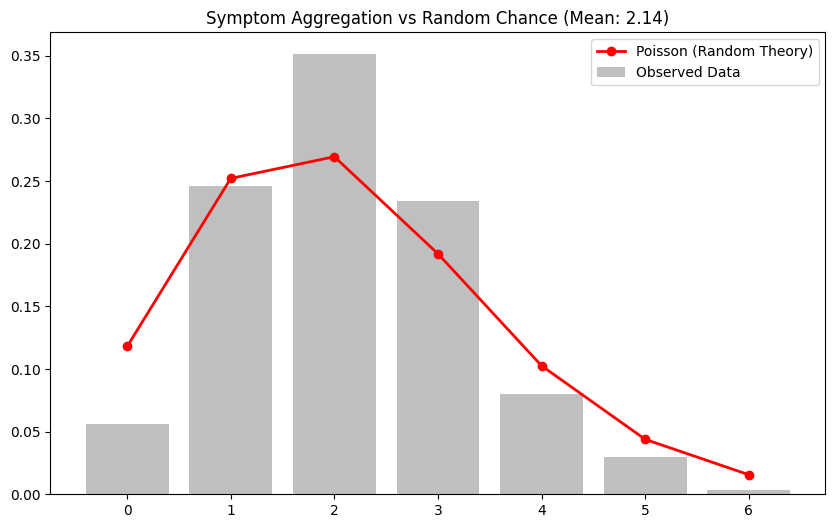

In [8]:
def run_poisson_analysis(data):
    """
    Compares actual symptom clustering against a random Poisson model.
    """
    logger.info("Running Poisson Distribution analysis.")
    symptom_list = ['Tremor', 'Rigidity', 'Bradykinesia', 'PosturalInstability', 
                    'SpeechProblems', 'SleepDisorders', 'Constipation']
    
    data['SymptomCount'] = data[symptom_list].sum(axis=1)
    mu = data['SymptomCount'].mean()
    
    # Calculate distributions
    actual = data['SymptomCount'].value_counts(normalize=True).sort_index()
    theoretical = [poisson.pmf(k, mu) for k in range(len(actual))]
    
    plt.figure(figsize=(10, 6))
    plt.bar(actual.index, actual.values, alpha=0.5, label='Observed Data', color='grey')
    plt.plot(actual.index, theoretical, 'ro-', linewidth=2, label='Poisson (Random Theory)')
    plt.title(f'Symptom Aggregation vs Random Chance (Mean: {mu:.2f})')
    plt.legend()
    plt.show()

# --- EXECUTION ---
if 'sick_df' in locals():
    run_poisson_analysis(sick_df)

cell 9: Gatekeeper Analysis: Impact of Specific Symptoms on Overall Disease Burden

2026-01-14 20:59:08,630 - INFO - Executing Gatekeeper Analysis (Tremor Paradox).
/tmp/ipykernel_20843/563220723.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=impact_df, x='Impact', y='Symptom', palette=colors)


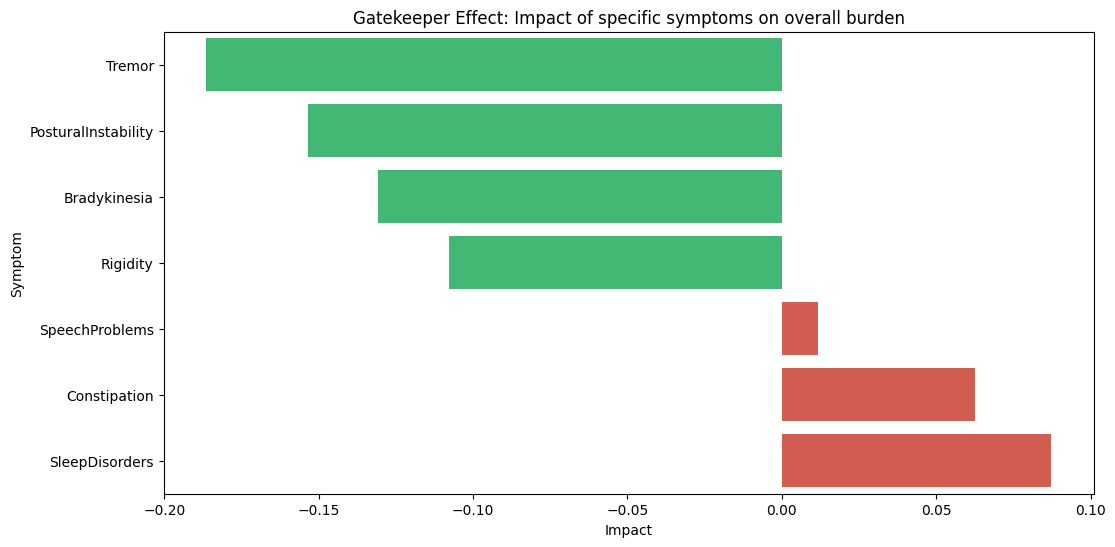

In [9]:
def run_gatekeeper_analysis(data):
    """
    Identifies which symptoms correlate with a higher or lower overall symptom burden.
    """
    logger.info("Executing Gatekeeper Analysis (Tremor Paradox).")
    symptoms = ['Tremor', 'Rigidity', 'Bradykinesia', 'PosturalInstability', 
                'SpeechProblems', 'SleepDisorders', 'Constipation']
    results = []

    for s in symptoms:
        others = [sym for sym in symptoms if sym != s]
        impact = data[data[s] == 1][others].sum(axis=1).mean() - data[data[s] == 0][others].sum(axis=1).mean()
        results.append({'Symptom': s, 'Impact': impact})

    impact_df = pd.DataFrame(results).sort_values(by='Impact')
    
    plt.figure(figsize=(12, 6))
    colors = ['#2ecc71' if x < 0 else '#e74c3c' for x in impact_df['Impact']]
    sns.barplot(data=impact_df, x='Impact', y='Symptom', palette=colors)
    plt.title('Gatekeeper Effect: Impact of specific symptoms on overall burden')
    plt.show()

# --- EXECUTION ---
if 'sick_df' in locals():
    run_gatekeeper_analysis(sick_df)

Cell 10: Disease Roadmap Analysis  